# Acoustic Source Localisation (ASL)

In [554]:
# Configuration

# NAME_EVALUATION = 'mean-err-n-sources'
# NAME_EVALUATION_OTHER = 'mean-err-n-sources-sample3and5exchanged'
# NAME_DATA_FILES = '2017-10-04*.txt'  # first trials, original speech samples

NAME_EVALUATION = 'mean-err-n-sources-sample3and5exchanged'
NAME_EVALUATION_OTHER = 'mean-err-n-sources'
NAME_DATA_FILES = '2017-10-11*.txt'  # second trials, rearranged speech samples

EXPORT = True

In [555]:
%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import glob
import csv
from os import path

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib2tikz import save as _tikz_save

NAME_SCATTER_PLOT = NAME_EVALUATION+'-scatter.tex'
NAME_BOX_PLOT = NAME_EVALUATION+'-box.tex'
NAME_BAR_PLOT = NAME_EVALUATION+'-bar.tex'
NAME_SUMMARY_TABLE = NAME_EVALUATION+'-summary.tex'
NAME_PERFECT_MATCHES_PLOT = NAME_EVALUATION+'-perfect-matches-bar.tex'
NAME_DATAFRAME = NAME_EVALUATION+'-dataframe.pkl'
NAME_DATAFRAME_OTHER = NAME_EVALUATION_OTHER+'-dataframe.pkl'

PATH_ROOT = '../matlab/mainczjs/evaluation/results/'
PATH_LATEX_PLOTS = '../latex/data/plots/'
PATH_LATEX_TABLES = '../latex/data/tables/'

PATH_SCATTER_PLOT = path.join(PATH_LATEX_PLOTS, NAME_SCATTER_PLOT)
PATH_BOX_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BOX_PLOT)
PATH_BAR_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BAR_PLOT)
PATH_LATEX_SUMMARY_TABLE = path.join(PATH_LATEX_TABLES, NAME_SUMMARY_TABLE)

lms_red = (204/255, 53/255, 56/255)

def _get_trial_index(t):
    return ["t{}".format(i+1) for i in range(t)]

def _get_col_name(s,post):
    return sum([("x{}{},y{}{}".format(n,post,n,post)).split(',') for n in range(1,s+1)],[])

def _get_err_col_name(s):
    return ["err{}".format(n) for n in range(1,s+1)]

def get_col_names(s):
    return sum([_get_col_name(s,""), _get_col_name(s,"est"), _get_err_col_name(s)], []) 

def is_x1_correct(row):
    if abs(row["x1"]-row["x1est"]) > 0.001:
        if abs(row["y1"]-row["y1est"]) > 0.001:
            return 1
    return 0

def tikz_save(*args, **kwargs):
    """Wrapper for tikz_save function, that always suppresses additional info output"""
    kwargs['show_info'] = False 
    _tikz_save(*args, **kwargs)

def adjust_y_axis(step_size, digits=0, min=None):
    start, end = plt.axes().get_ylim()
    if min==None: min=start
    plt.yticks(np.arange(min, round(end+step_size, digits), step_size))

## Get Data

In [556]:
summary_columns = ['n_trials', 'mean_err', 'perfect_matches']
n_sources_range = [2, 3, 4, 5, 6, 7]
results_dict = {}
summary_index = n_sources_range
summary = pd.DataFrame(index=range(0,len(n_sources_range)),columns=summary_columns)
summary.index = eval_index

for s in n_sources_range:
    # define filename format
    files = glob.glob(path.join(PATH_ROOT,"{}sources".format(s), NAME_DATA_FILES))

    # load data
    dfs = []
    for f in files:
        dfs.append(pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float))
    try:   
        results = pd.concat(dfs)
    except ValueError:
        continue
    n_trials = len(results)
    n_sources = int((len(results.columns)-1)/5)
    results.drop(results.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
    results.columns = get_col_names(n_sources)
    results.index = ["t{}".format(i+1) for i in range(n_trials)]
    results_dict['{}'.format(n_sources)] = results
    
    # calculate helper columns
    results['n_sources'] = n_sources
    results["err_total"] = results.loc[:, "err1":_get_err_col_name(s)[-1]].sum(axis=1)
    results["perfect_match"] = results["err_total"]==0

    # calculate statistics
    mean_err = results.mean()["err1":"err{}".format(s)].mean() 
    perfect_matches = round(sum(results["err_total"]==0)/results["err_total"].count(),3)
    
    # saving statistics to data summary
    summary.set_value(n_sources, 'n_trials', n_trials)
    summary.set_value(n_sources, 'mean_err', round(mean_err,3))
    summary.set_value(n_sources, 'perfect_matches', perfect_matches)

results = pd.concat(results_dict, ignore_index=True)
results["err_mean"] = results.loc[:, "err1":"err7"].mean(axis=1)
print("SUMMARY:")
print(summary.transpose())
print("")
print("COMPLETE DATA:")
print(results.sample(5))
if EXPORT:
    summary.transpose().to_latex(PATH_LATEX_SUMMARY_TABLE, column_format="rrrrrrr", bold_rows=True)
    results.to_pickle(path.join(PATH_ROOT, NAME_DATAFRAME))

SUMMARY:
                     2      3      4      5      6      7
n_trials            70     70     70     70     70     70
mean_err         0.021  0.068  0.152  0.258  0.334  0.289
perfect_matches  0.914  0.843  0.557    0.4  0.171  0.257

COMPLETE DATA:
     err1      err2  err3  err4      err5      err6  err7  err_total  \
353   0.0  0.000000   0.0   0.0  0.000000  2.402082   0.0   2.402082   
285   0.0  0.223607   0.1   0.1  2.433105  3.534119   NaN   6.390831   
125   0.0  0.000000   0.0   NaN       NaN       NaN   NaN   0.000000   
44    0.0  0.000000   NaN   NaN       NaN       NaN   NaN   0.000000   
267   0.0  0.000000   0.0   0.0  0.806226       NaN   NaN   0.806226   

     n_sources  perfect_match    ...     y3est   y4  y4est   y5  y5est   y6  \
353          7          False    ...       3.1  2.2    2.2  4.1    4.1  1.5   
285          6          False    ...       1.6  3.9    3.9  4.8    2.4  2.4   
125          3           True    ...       3.8  NaN    NaN  NaN    NaN  N

## Plot Results

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


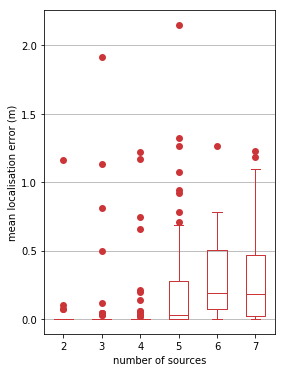

In [551]:
# Scatter Plot
bp = results.boxplot('err_mean', by='n_sources',figsize=(4,6),return_type='both')

# style boxplot output
fig = bp[0].ax.get_figure()
for key in bp[0].lines.keys():
    for item in bp[0].lines[key]:
        item.set_color(lms_red)
for item in bp[0].lines['fliers']:
    item.set_markerfacecolor(lms_red)
    item.set_markeredgewidth(0)
    item.set_markeredgecolor(lms_red)
    item.set_markersize(7)

fig.suptitle('')
plt.title("")
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis='x')
if EXPORT:
    tikz_save(PATH_BOX_PLOT, show_info=False)

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


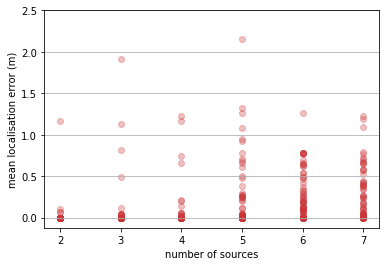

In [465]:
# Scatter Plot
x = pd.to_numeric(results['n_sources'].values)  # without to_numeric(), tikz_save() fails (TypeError: str instead of int)
y = results["err_mean"].values
plt.scatter(x, y, alpha=0.3, c=lms_red)
plt.xticks(n_sources_range)
adjust_y_axis(step_size=0.5, digits=2, min=0)
plt.grid(True, axis='y')
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
if EXPORT:
    tikz_save(PATH_SCATTER_PLOT, show_info=False)

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


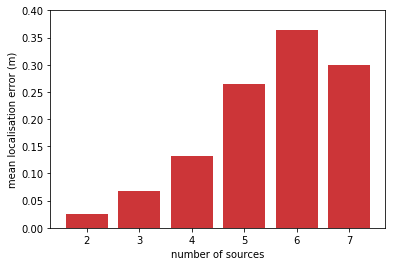

In [466]:
# Bar Plot
plt.bar(eval_data.index, height=eval_data['mean_err'], color=lms_red)
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
adjust_y_axis(step_size=0.05, digits=2)
if EXPORT_TO_LATEX:
    tikz_save(PATH_BAR_PLOT)

## Compare Trials

### T-Test

In [467]:
from scipy.stats import ttest_ind, describe
from statsmodels.formula.api import ols

# print(results[['err_mean', 'n_sources']])

cat2 = results[results['n_sources']==2]['err_mean']
cat3 = results[results['n_sources']==3]['err_mean']
cat4 = results[results['n_sources']==4]['err_mean']
cat5 = results[results['n_sources']==5]['err_mean']
cat6 = results[results['n_sources']==6]['err_mean']
cat7 = results[results['n_sources']==7]['err_mean']

# ttest_ind(cat2, cat4, equal_var=False)
# model = ols("err_mean ~ n_sources + 1", results).fit()
# print(model.summary())

### Perfect matches

<Container object of 6 artists>

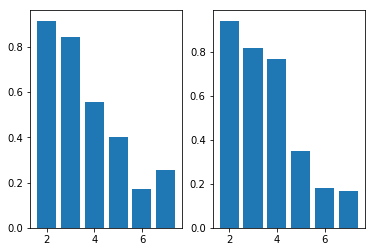

In [557]:
plt.subplot(121)
df = pd.read_pickle(path.join(PATH_ROOT, NAME_DATAFRAME))
dfpm = df.pivot_table("perfect_match", columns="n_sources", aggfunc='mean').transpose()
plt.bar(dfpm.index, height=dfpm.values)

plt.subplot(122)
df2 = pd.read_pickle(path.join(PATH_ROOT, NAME_DATAFRAME_OTHER))
dfpm2 = df2.pivot_table("perfect_match", columns="n_sources", aggfunc='mean').transpose()
plt.bar(dfpm2.index, height=dfpm2.values)